[Inhaltsverzeichnis](../AP4.ipynb) | [ < zurück ](wohin?)|  [ > next](wohin?)

## 4.1.0 Datenaufbereitung

### Electricity Map
Die im folgenden verwendeten Daten für Österreich (2015-2017, 2018-2019) stammen von
[electricitymap.org](https://www.electricitymap.org/map). Basis für die dort verwendeten globalen mittleren
CO2-Intensitäten ist folgender [IPCC Bericht aus dem Jahr 2014](https://en.wikipedia.org/wiki/Life-cycle_greenhouse-gas_emissions_of_energy_sources#2014_IPCC.2C_Global_warming_potential_of_selected_electricity_sources).


In [15]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

FLUCCOplus.notebooks loaded!
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from FLUCCOplus.notebooks import *
import FLUCCOplus.electricitymap as elmap

Es stehen zwei Datensätze zur Verfügung:
* 2015 - 2017 *Electricity_map_CO2_AT_2015_2017.csv*
* 2018 - 2019 *Electricity_map_CO2_AT_2018_2019.csv*

### Electricity Map 2018-19

### Combine 2015-17 with 18-19
Electricity map dataframe (common cols)

In [17]:
em18 = (elmap.read_raw("Electricity_map_CO2_AT_2018_2019.csv")
      .pipe(elmap.start_pipeline)
      .drop(elmap.header_junk, axis=1)
      .astype(float)
      # .fillna(0)
      )
em18set = set(em18.columns)

read_raw took 0:00:00.219009
start_pipeline took 0:00:00.003983 for 17505 rows, 83 columns in df


In [18]:
em18 = elmap.read_raw("Electricity_map_CO2_AT_2018_2019.csv")
em18.info()

read_raw took 0:00:00.224490
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17505 entries, 2018-01-01 00:00:00+00:00 to 2019-12-31 23:00:00+00:00
Data columns (total 83 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Jahr                                          17505 non-null  int64  
 1   monat                                         17505 non-null  int64  
 2   Tag                                           17505 non-null  int64  
 3   Stunde                                        17505 non-null  int64  
 4   Datum                                         17505 non-null  object 
 5   Tag des Jahres                                17505 non-null  int64  
 6   Tag des Monats                                17505 non-null  int64  
 7   Uhrzeit                                       17505 non-null  object 
 8   timestamp                                     17505 non-null

In [19]:
em15 = (elmap.read_raw("Electricity_map_CO2_AT_2015_2017.csv")
        .pipe(elmap.start_pipeline)
        .pipe(elmap.clean151617)
       )
em15set = set(em15.columns)

read_raw took 0:00:00.294516
start_pipeline took 0:00:00.001000 for 26304 rows, 18 columns in df
start_pipeline took 0:00:00.001953 for 26304 rows, 18 columns in df
clean151617 took 0:00:00.008968 for 26304 rows, 16 columns in df


### Shared columns

In [20]:
common_cols = list(em15set & em18set)
common_cols

['total_export_avg',
 'carbon_intensity_avg',
 'total_consumption_avg',
 'total_import_avg',
 'total_production_avg']

### Columns only in 15-17:
*"power_origin_precent_XXX_avg"*


In [21]:
em15unique = sorted([c for c in em15set if c not in em18set])
em18unique = sorted([c for c in em18set if c not in em15set])

em15[em15unique].sum(axis=0)

power_origin_percent_biomass_avg            149723.196980
power_origin_percent_coal_avg               401404.299577
power_origin_percent_gas_avg                298150.840382
power_origin_percent_geothermal_avg             99.989270
power_origin_percent_hydro_avg              990461.055664
power_origin_percent_hydro_discharge_avg    122688.178610
power_origin_percent_nuclear_avg            189635.419717
power_origin_percent_oil_avg                  2353.144660
power_origin_percent_solar_avg               71735.992395
power_origin_percent_unknown_avg            122431.629931
power_origin_percent_wind_avg               272816.252813
dtype: float64

Diese *origin percents* müssen sich aufgrund von Anteilen Kohle, Nuklear, etc.
also **power_consumptions** sein und nicht *power_productions*

Damit erhalten wir für diese Zeitreihen power_consumptions für alle Energieträger.

*Die  Energie**produktion** je Energieträger  lässt sich für die Jahre 2015 - 2017 aus
 den Electricity Map Daten **nicht** ableiten.*


In [22]:

em15 = elmap.calc_power_consumption_from_percent(em15)

em15.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26304 entries, 2015-01-01 00:00:00+00:00 to 2017-12-31 23:00:00+00:00
Data columns (total 28 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   total_production_avg                      26304 non-null  float64
 1   total_consumption_avg                     26304 non-null  float64
 2   total_import_avg                          26304 non-null  float64
 3   total_export_avg                          26304 non-null  float64
 4   carbon_intensity_avg                      26215 non-null  float64
 5   power_origin_percent_biomass_avg          26215 non-null  float64
 6   power_origin_percent_coal_avg             26215 non-null  float64
 7   power_origin_percent_gas_avg              26215 non-null  float64
 8   power_origin_percent_hydro_avg            26215 non-null  float64
 9   power_origin_percent_nuclear_avg          26215 non-null  

> Check: geht sich jede zeile auf 100% aus?

,Total,Sum of origins
datetime,,
2015,60190.0,60190.0
2016,60880.0,60933.0
2017,63459.0,63459.0


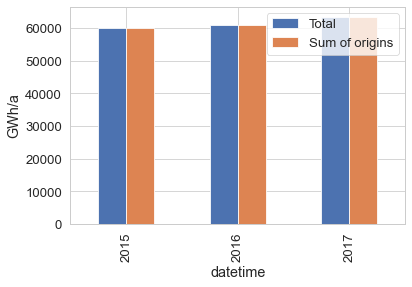

In [23]:
total = em15["total_consumption_avg"].groupby(em15.index.year).sum().round(-3)/1000
sum = em15[elmap.pcs].groupby(em15.index.year).sum().sum(axis=1).round(-3)/1000
comparison = pd.DataFrame([total,sum], index=["Total","Sum of origins"]).transpose()
comparison.plot.bar(ylabel="GWh/a")
comparison

Daraus ergeben sich folgende Variablen, für die von 2015 bis 2017 Daten vorliegen:

In [24]:
em15set = set(em15.columns)
common_cols = list(em15set & em18set)
sorted(common_cols)

['carbon_intensity_avg',
 'power_consumption_battery_discharge_avg',
 'power_consumption_biomass_avg',
 'power_consumption_coal_avg',
 'power_consumption_gas_avg',
 'power_consumption_geothermal_avg',
 'power_consumption_hydro_avg',
 'power_consumption_hydro_discharge_avg',
 'power_consumption_nuclear_avg',
 'power_consumption_oil_avg',
 'power_consumption_solar_avg',
 'power_consumption_unknown_avg',
 'power_consumption_wind_avg',
 'total_consumption_avg',
 'total_export_avg',
 'total_import_avg',
 'total_production_avg']

In [25]:
em15[common_cols].shape

(26304, 17)

In [26]:
em18[common_cols].shape

(17505, 17)

In [27]:
em = pd.concat([em15[common_cols], em18[common_cols]])
em.shape

(43809, 17)

,power_consumption_biomass_avg,power_consumption_hydro_avg,power_consumption_solar_avg,power_consumption_wind_avg,power_consumption_geothermal_avg,power_consumption_coal_avg,power_consumption_gas_avg,power_consumption_nuclear_avg,power_consumption_oil_avg,power_consumption_unknown_avg,power_consumption_battery_discharge_avg,power_consumption_hydro_discharge_avg
datetime,,,,,,,,,,,,
2015,3034.0,19956.0,1654.0,5734.0,1.0,10548.0,7214.0,4785.0,61.0,5793.0,0.0,1409.0
2016,3451.0,24801.0,1583.0,5610.0,2.0,8926.0,7177.0,3996.0,47.0,1169.0,0.0,4171.0
2017,3693.0,23754.0,1908.0,7529.0,3.0,8797.0,8441.0,4092.0,55.0,1358.0,0.0,3830.0
2018,3812.0,24594.0,2255.0,7359.0,1.0,8504.0,7575.0,4382.0,17.0,897.0,0.0,4102.0
2019,3201.0,24140.0,1929.0,8334.0,0.0,5871.0,8469.0,3509.0,52.0,484.0,0.0,3531.0


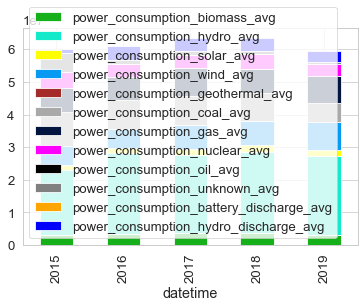

In [28]:
fig, ax = plt.subplots()

em["total_consumption_avg"].groupby(em.index.year).sum().plot(kind="line",ax=ax)
em[elmap.pcs].groupby(em.index.year).sum().plot(kind="bar", color=elmap.carrier_colors.values(), stacked=True, ax=ax)
em[elmap.pcs].groupby(em.index.year).sum().round(-3)/1000

## Save cleaned combined DF

In [29]:
em.to_csv(DATA_INTERIM / "em_common_15-19.csv",
          sep=";",
          decimal=",",
          encoding="cp850")


### Datenlücken

https://jakevdp.github.io/PythonDataScienceHandbook/03.04-missing-values.html

In [30]:

# forward-fill
# data.fillna(method='ffill')


#separate in years

df_dict = elmap.split_into_years(em)





split_into_years took 0:00:00.024540
